In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")


In [2]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [3]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [4]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [5]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten(x, y, return_trend=False):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    if return_trend:
        return y / np.polyval(p, x), np.polyval(p, x)
    return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)

def flatten(x, y):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    return y / np.polyval(p, x)

In [6]:
def get_spectrum(spec, orders, smooth_f=0):
    spec_data = pf.getdata(spec)
    wav = np.log(spec_data[3,:,:])
    flux = spec_data[0,:,:] / spec_data[2,:,:]
    
    all_wav, all_flux = [], []
    for w, f in zip(wav[orders], flux[orders]):
#         ivars = np.ones_like(w)
#         mu = fit_continuum(w, f, ivars, order=10)
#         f /= mu
        f = flatten(w, f)
        f = smooth(w, f, factor=smooth_f)
#         f = flatten(w, f)
        all_wav.extend(w)
        all_flux.extend(f)

    all_wav, all_flux = np.array(all_wav), np.array(all_flux)
    all_flux /= np.median(all_flux)
    return all_wav, all_flux

In [7]:
def rv_ccf_mask(spectrum, diagnose=False, ax=None):
#     mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)

    models, ccf = ispec.cross_correlate_with_mask(spectrum, ccf_mask, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, mask_depth=0.1, mask_size=2.0, 
                            fourier=False, only_one_peak=True)
    
    if diagnose:
        if ax is None:
            fig, ax = plt.subplots()
        plt.plot(ccf['x'], ccf['y'], lw=1, color='b', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='b', zorder=1)
        plt.fill_between(ccf['x'], ccf['y']+ccf['err'], ccf['y']-ccf['err'], color='#CCCCCC')
        for model in models:
            plt.plot(ccf['x'], model(ccf['x']), lw=1, color='r', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='r', zorder=2)
        plt.show()
#     if len(models) > 1:
#         return models[0].mu(), models[1].mu()#, models[1].mu(), models[1].emu()
    return models[0].mu(), models[0].emu()

## Clean spectra

In [8]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
all_spectra_files = all_spectra_files[m]

orders = [18,19,20,21,22,23,24,25,26]
# orders = [15, 16, 17]
# orders=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
#18,19,20,21,22,23,24,25,

# all_rv, all_rv_err = [], []
times = []
all_spectra = []
all_meta = []

for spec in tqdm.tqdm(all_spectra_files[:]):

    wav, flux = get_spectrum(spec, orders)
    meta = pf.getheader( spec )
    all_meta.append(meta)
    times.append(meta['BJD-MID'])
    
    m = wav < np.inf
    wav, flux = wav[m], flux[m]
    flux /= np.median(flux)
    
#     np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav, flux)))
#     star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    star_spectrum = ispec.create_spectrum_structure(wav)
    star_spectrum['flux'] = flux
    
    all_spectra.append(star_spectrum)

100%|██████████| 59/59 [00:02<00:00, 24.42it/s]


# Resample

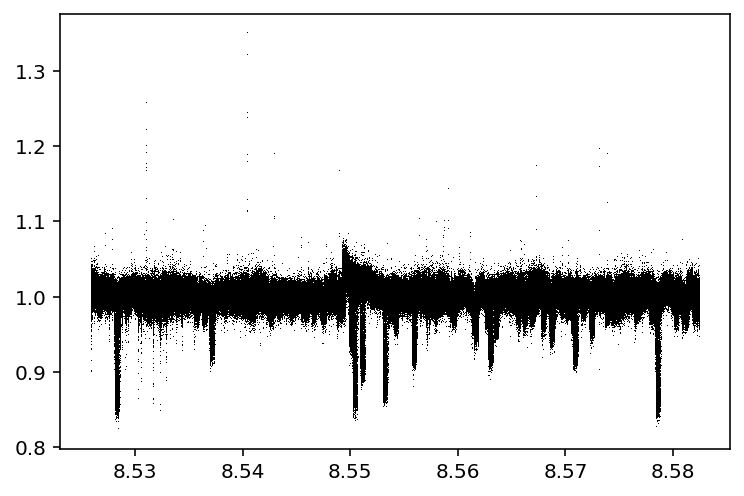

In [9]:
wavelengths = np.arange(all_spectra[0]['waveobs'].min()+0.01, all_spectra[0]['waveobs'].max()-0.01, 0.000003) # 0.2 A
# wavelengths = np.arange(all_spectra[0]['waveobs'].min()+0.5, all_spectra[0]['waveobs'].max()-0.5, 0.002) # 0.2 A
resampled = np.array([interpolate_spectrum(spec['waveobs'], spec['flux'], wavelengths) for spec in all_spectra])
plt.plot(wavelengths, resampled.T, ',k');

# Cross correlate with self

In [10]:
from scipy.optimize import curve_fit

def model(x, a, d, x0):
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2))
    return gaussian

In [11]:
template = resampled[0]
all_rv_primary = []
rv_previous = 0


for i in tqdm.tqdm(range(20)):
    rv_primary, rv_primary_err = [], []
    all_lags, all_acors = [], []
    for i, spec in enumerate(resampled[:]):
        acor = np.correlate(template - 1., spec - 1., mode='full')
        df = wavelengths[1] - wavelengths[0]
        lags =  (299792.458) * (df*np.arange(-len(acor)//2, len(acor)//2)) - rv_previous

        # Fit gaussians
        m = (lags < 70) & (lags > -70)
        x0 = [np.max(acor[m]), 20, lags[m][np.argmax(acor[m])]]
        popt, pcov = curve_fit(model, lags[m], acor[m], p0=x0)
        rv_primary.append(popt[2])
        rv_primary_err.append(np.sqrt(np.diag(pcov))[2])
        
        all_lags.append(lags)
        all_acors.append(acor)
        # Plot
#         plt.plot(lags, acor - i*1, c='C0', alpha=0.5)
#         plt.plot(lags, model(lags, *popt) - i*1, c='red', lw=0.7)
#         plt.xlim(-70, 70)
#     plt.show()
    
    all_rv_primary.append(rv_primary)
    rv_primary = np.array(rv_primary)
    c = 299792.458
    temp_array = np.array([interpolate_spectrum(spec['waveobs']-np.log(np.sqrt((1 - rv / c) / (1 + rv / c))),
                                                spec['flux'], wavelengths) for spec, rv in 
                          zip(all_spectra, rv_primary)])
    template = np.median(temp_array, axis=0)
    rv_previous = rv_primary[0]

100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


In [12]:
np.all(np.diff(all_rv_primary, axis=0)[-1] < 0.00001)

True

# Cross correlate with atomic linelist to get absolute RVs

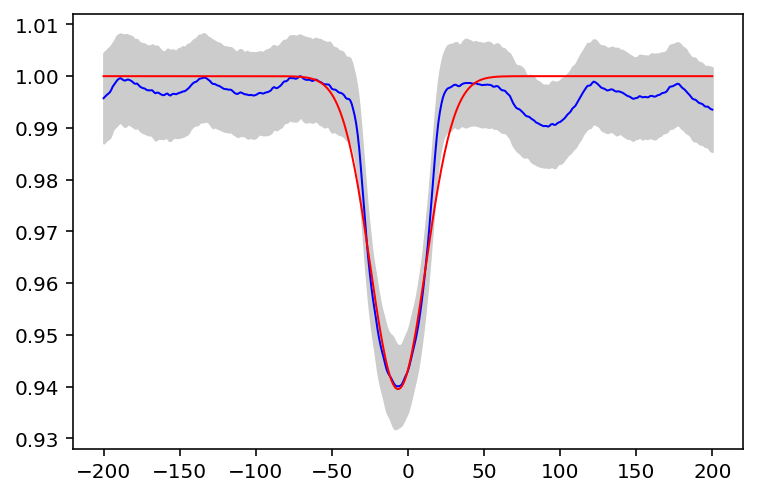

In [13]:
template_spectrum = ispec.create_spectrum_structure(np.exp(wavelengths) / 10)
template_spectrum['flux'] = np.median(temp_array, axis=0)
template_spectrum['err'] = np.std(temp_array, axis=0)

rv_offset, rv_offset_err = rv_ccf_mask(template_spectrum, diagnose=True)

(531.0, 532.0)

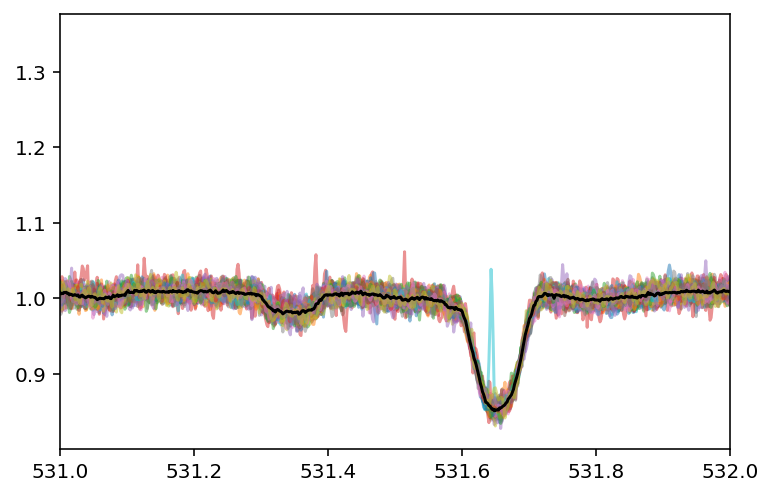

In [14]:
plt.plot(np.exp(wavelengths) / 10, temp_array.T, alpha=0.5);
plt.plot(template_spectrum['waveobs'], template_spectrum['flux'], c='black')
plt.xlim(531, 532)

In [15]:
rv_offset

-6.500000000000096

# Convert to radial velocities

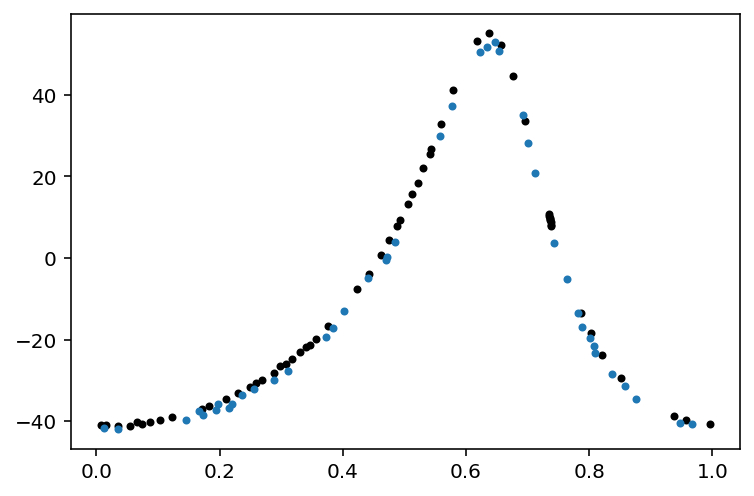

In [20]:
import astropy.units as u
porb = 51.4213
bvcs = [pf.getheader( spec )['BVC'] for spec in all_spectra_files]

rv = -1*(rv_primary) + rv_offset
rv = rv + bvcs + rv * bvcs / 299792.458
# rv += rv_offset
plt.plot((np.array(times)+2400000) % porb / porb, rv, '.k')

bischoff_x, bischoff_y = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T
plt.plot((bischoff_x + 2457000) % porb / porb, bischoff_y, '.')

In [73]:
np.savetxt('data/RV/SONG.txt', list(zip(np.array(times), rv, rv_primary_err)))
# np.savetxt('data/RV/wav_shifts.txt', list(zip(wav_shift_primary, wav_shift_uncertainty)))

(5.0, 12.0)

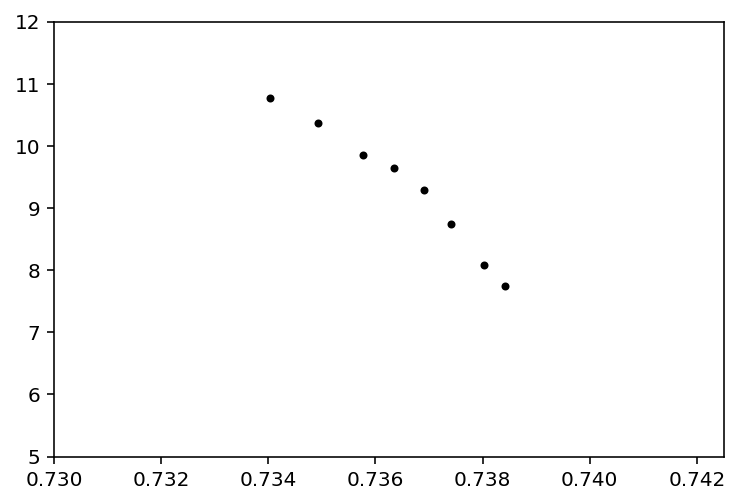

In [130]:

plt.plot((np.array(times)+2400000) % porb / porb, rv, '.k')

bischoff_x, bischoff_y = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T
plt.plot((bischoff_x + 2457000) % porb / porb, bischoff_y, '.')
plt.xlim(0.73, 0.7425)
plt.ylim(5, 12)

# Make observation table

In [21]:
time, RV, RV_err = np.loadtxt('data/RV/SONG.txt', unpack=True)
time += 2400000

for i in range(len(all_meta)):
    snr =ispec.estimate_snr(all_spectra[i]['flux'], num_points=10)
    print(f"{all_meta[i]['OBS-MID'].split('T')[0]} & {time[i] :.4f} & {time[i] % 51.4213 / 51.4213 :.3f} & {snr:.0f} & {RV[i]:.1f}\,$\pm$\,{RV_err[i]:.1f}")
# for spec in all_spectra[:1]:
#     snr = ispec.estimate_snr(spec['flux'], num_points=10)
#     print(snr)

2019-10-28 & 2458785.3134 & 0.475 & 86 & 4.4\,$\pm$\,0.1
2019-11-01 & 2458788.7821 & 0.543 & 103 & 26.7\,$\pm$\,0.1
2019-11-17 & 2458804.6782 & 0.852 & 115 & -29.5\,$\pm$\,0.1
2019-11-25 & 2458812.7061 & 0.008 & 59 & -41.0\,$\pm$\,0.2
2019-11-28 & 2458815.6997 & 0.066 & 138 & -40.3\,$\pm$\,0.1
2019-11-29 & 2458816.7830 & 0.087 & 128 & -40.2\,$\pm$\,0.2
2019-11-30 & 2458817.6497 & 0.104 & 119 & -39.8\,$\pm$\,0.2
2019-12-01 & 2458818.6397 & 0.123 & 127 & -39.0\,$\pm$\,0.1
2019-12-04 & 2458821.6927 & 0.183 & 145 & -36.4\,$\pm$\,0.1
2019-12-08 & 2458825.6532 & 0.260 & 107 & -30.7\,$\pm$\,0.1
2019-12-10 & 2458827.6502 & 0.298 & 117 & -26.6\,$\pm$\,0.1
2019-12-11 & 2458828.6200 & 0.317 & 114 & -24.8\,$\pm$\,0.1
2019-12-12 & 2458829.7898 & 0.340 & 112 & -21.8\,$\pm$\,0.1
2019-12-13 & 2458830.6016 & 0.356 & 93 & -19.7\,$\pm$\,0.1
2019-12-14 & 2458831.6115 & 0.376 & 127 & -16.7\,$\pm$\,0.1
2019-12-20 & 2458837.6224 & 0.492 & 121 & 9.2\,$\pm$\,0.1
2019-12-21 & 2458838.6407 & 0.512 & 140 & 15.7\,

# Final corrected stacked spectrum

In [19]:
corr = np.copy(template_spectrum)
corr = ispec.correct_velocity(corr, rv_offset)

(505.0, 507.0)

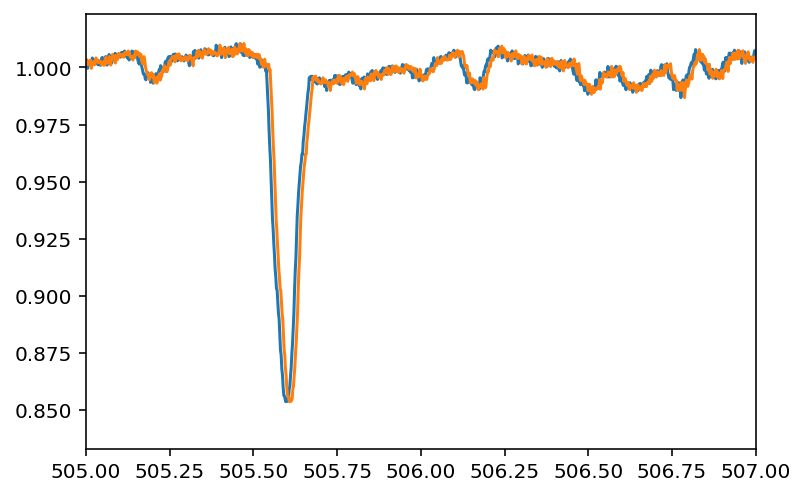

In [20]:
bkg = estimate_background(wavelengths, template, log_width=0.00015)
plt.plot(wavelengths, template)
plt.plot(corr['waveobs'], corr['flux'])
plt.xlim(505, 507)

# plt.plot(wavelengths, bkg)
# plt.xlim(505, 510)

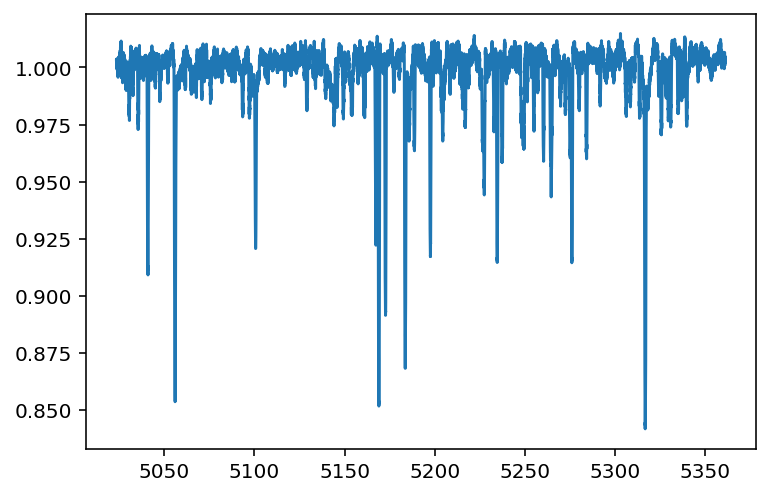

In [22]:
plt.plot(corr['waveobs'] * 10, corr['flux'])
# plt.xlim(505, 507)

In [45]:
np.savetxt('data/Spectra/primary_stacked.txt', corr)

In [26]:
all_lags = np.array(all_lags)
all_acors = -1*np.array(all_acors)

In [27]:
all_lags.shape

(59, 37707)

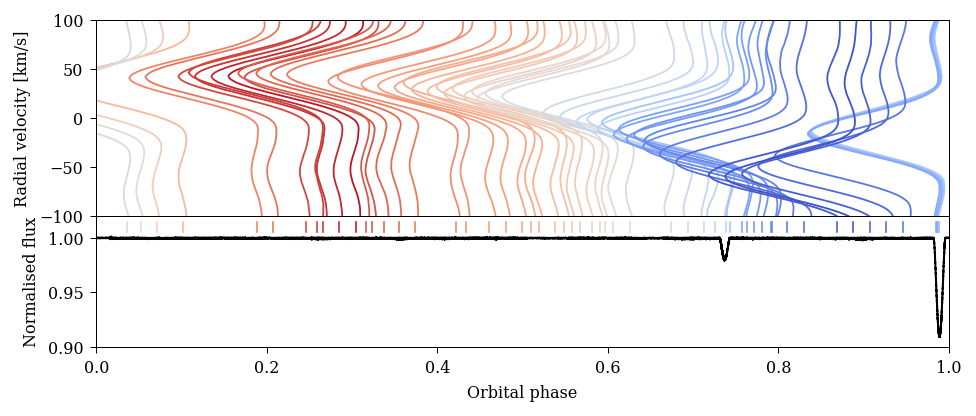

In [30]:
import seaborn as sns
colors = np.array(sns.color_palette('coolwarm_r', n_colors=len(RV)))
# colors = np.array(sns.color_palette('bwr_r', n_colors=len(RV)))


with plt.style.context('science'):
    t, y, yerr = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
    fig, axes = plt.subplots(2,1, figsize=[7.64, 3.], gridspec_kw={'height_ratios':[0.6,0.4]})

    tjd_0 = 2457000
    t += tjd_0

    porb = 51.41888#51.4213
    t0 = 2458696.0199

    ax = axes[1]
    fold = t % porb / porb
    sort = np.argsort(fold)
    ax.plot(fold[sort],y[sort], c='k')

    ax.set_xlim(0,1)
    ax.set_ylim(0.90, 1.02)
    ax.set_xlabel('Orbital phase')
    ax.set_ylabel('Normalised flux')

    ax = axes[0]

    rv_sort = np.argsort(rv)
    for i in range(len(np.array(all_lags))):
        c_phase = (np.array(times)[rv_sort][i] + 2400000) % porb / porb
        axes[1].plot([c_phase, c_phase], [1.015, 1.005], linewidth=0.8, alpha=1., color=colors[i])
        normed = -1*(all_acors[rv_sort][i] / np.max(all_acors[rv_sort][i])) * 0.15
        ax.plot(normed - normed[0] + c_phase, all_lags[rv_sort][i], color=colors[i], lw=0.9)

    ax.set_xlim(0, 1)
    ax.set_ylim(-100, 100)
    ax.set_ylabel('Radial velocity [km/s]')
    ax.set_xticks([])

    plt.subplots_adjust(hspace=0.)


overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'
plt.savefig(overleaf_path+'rv_ccf.pdf', dpi=300, bbox_inches='tight')

## Create primary template by shifting and stacking

In [31]:

orders=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
#18,19,20,21,22,23,24,25,

all_spectra = []

for spec in tqdm.tqdm(all_spectra_files[:]):

    wav, flux = get_spectrum(spec, orders)
    meta = pf.getheader( spec )
    all_meta.append(meta)
    times.append(meta['BJD-MID'])
    
    m = wav < np.inf#5500
    wav, flux = wav[m], flux[m]
    flux /= np.median(flux)
    
#     np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav / 10, flux, np.ones_like(flux) * 0.01)))
#     star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    star_spectrum = ispec.create_spectrum_structure(wav / 10)
    star_spectrum['flux'] = flux
    
    all_spectra.append(star_spectrum)

100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


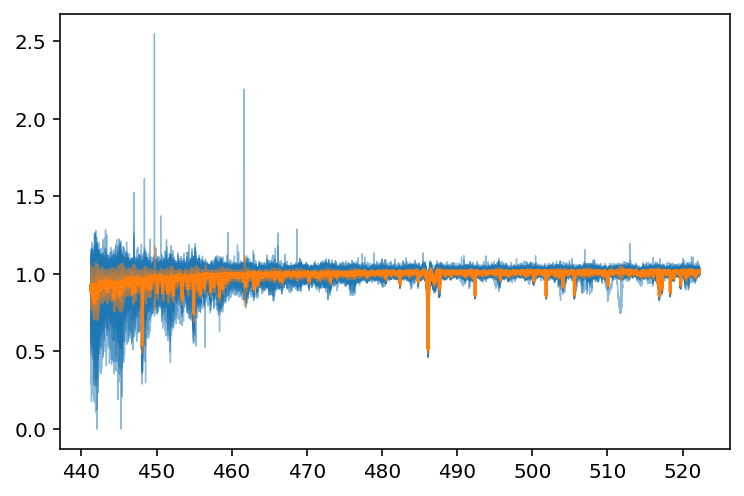

In [48]:
corr_spectra = []
# wavelengths = np.linspace(star_spectrum['waveobs'].min()+1, star_spectrum['waveobs'].max()-1, 6142)
wavelengths = np.arange(star_spectrum['waveobs'].min()+3, star_spectrum['waveobs'].max()-3, 0.002) # 0.2 A
# wavelengths = np.arange(star_spectrum['waveobs'].min()+3, star_spectrum['waveobs'].max()-3, 0.035)

# 78895
coadded_spectrum = ispec.create_spectrum_structure(wavelengths)

for spectra, rv in zip(all_spectra, RV):
    corr = np.copy(spectra)
    corr = ispec.correct_velocity(corr, rv)
    
    corr = ispec.resample_spectrum(corr, wavelengths, zero_edges=True)
    corr_spectra.append(corr)
    plt.plot(corr['waveobs'], corr['flux'], alpha=0.5, c='C0', lw=0.7)

corr_spectra = np.array(corr_spectra)
coadded_spectrum['flux'] = np.median(corr_spectra['flux'], axis=0)
coadded_spectrum['err'] = np.std(corr_spectra['flux'], axis=0)

plt.plot(coadded_spectrum['waveobs'], coadded_spectrum['flux'], c='C1')
plt.fill_between(coadded_spectrum['waveobs'], coadded_spectrum['flux'] - coadded_spectrum['err'], coadded_spectrum['flux'] + coadded_spectrum['err'], color='C1', alpha=0.5, zorder=50)

In [50]:
np.savetxt('coadded_SONG.txt', list(zip(coadded_spectrum['waveobs'] * 10, coadded_spectrum['flux'], coadded_spectrum['err'])))

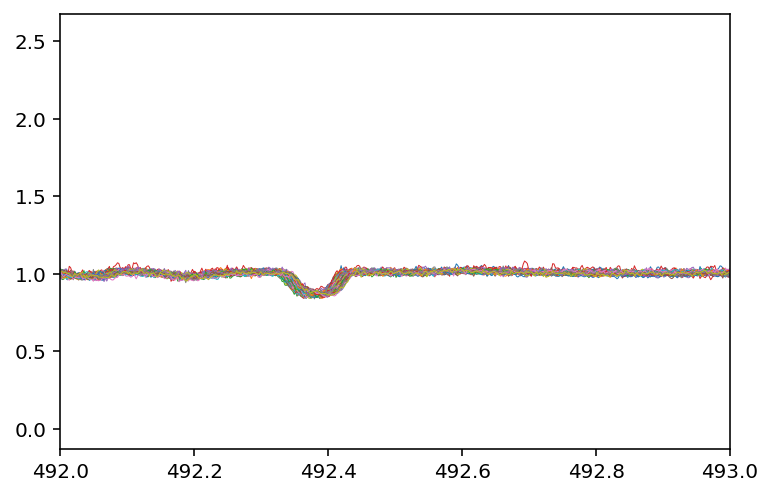

In [55]:
for corr in corr_spectra:
    plt.plot(corr['waveobs'], corr['flux'], lw=0.5);
    plt.xlim(492, 493)

In [56]:
coadded_spectrum['err']

array([0.07481396, 0.09045342, 0.07633585, ..., 0.00913426, 0.00860192,
       0.00803461])